# Predicting the Occurrence of Diabetes with Logistic Regression

## Executive Summary

Two models designed to predict the occurrence of diabetes were developed and evaluated. The first model (referred to as the full model) included eight predictor variables and the second model (referred to as the reduced model) included seven predictor variables. 

Both models had similar performance, therefore the reduced model was selected as the superior model.  

The reduced model's performance is described in the table below.

| Metric      | Description                         | Value  |
|:-------------:|:-------------------------------------:|:--------:|
| Accuracy    | Correct predictions.                | 84.65% |
| Sensitivity | True positives predicted correctly. | 84.48% |
| Specificity | True negatives predicted correctly. | 87.88% |

## Applications

One application for the model is as a screening tool for individuals who may be at risk for diabetes. To help determine if a patient should undergo additional testing for diabetes, s/he could enter the relevant health information into a web app. A prototype of the web app can be accessed at https://1l6ts2-christopher-taylor.shinyapps.io/diabetes_prediction_app/

# R Code

In [29]:
# Packages Used
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(car))
library(Boruta)
library(tidyverse)
library(broom)

In [30]:
# Set size of plots
options(repr.plot.width=12, repr.plot.height=8, scipen=4)

## Exploratory Data Analysis and Data Wrangling

In [31]:
# Creating variable to hold url 
urlfile <- 'https://raw.githubusercontent.com/CJTAYL/data/main/diabetes.csv'

In [32]:
# Loading data from GitHub
df <- read_csv(url(urlfile), show_col_types=FALSE)

### Age

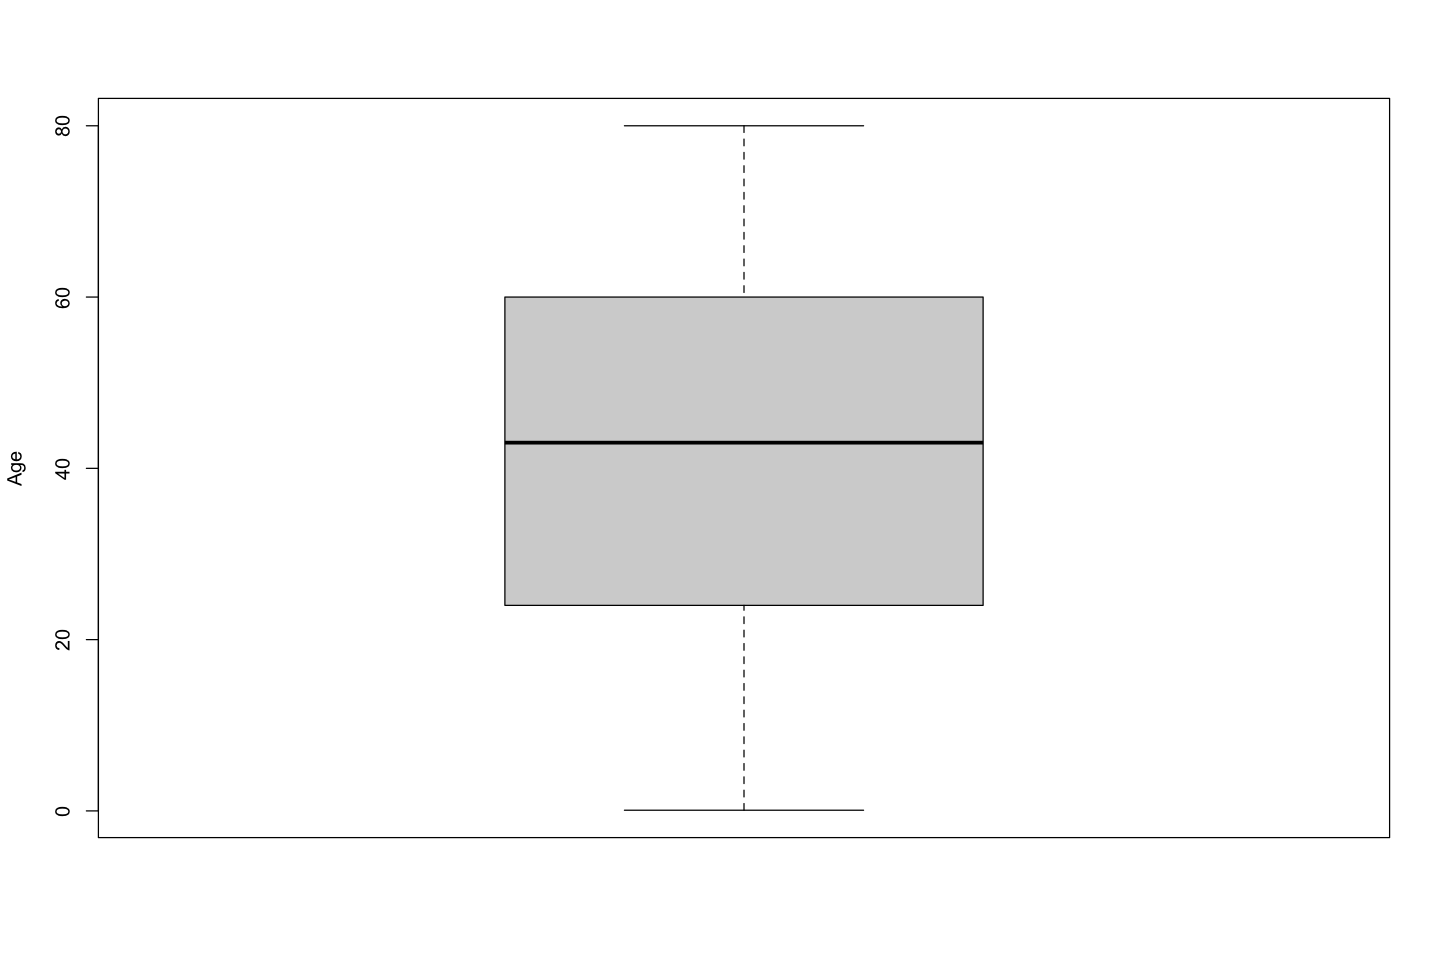

In [33]:
boxplot(df$age, ylab='Age')

Based on the boxplot and review of the data using the IQR criterion, there do not appear to be any outliers in the data set with respect to age. 

### BMI

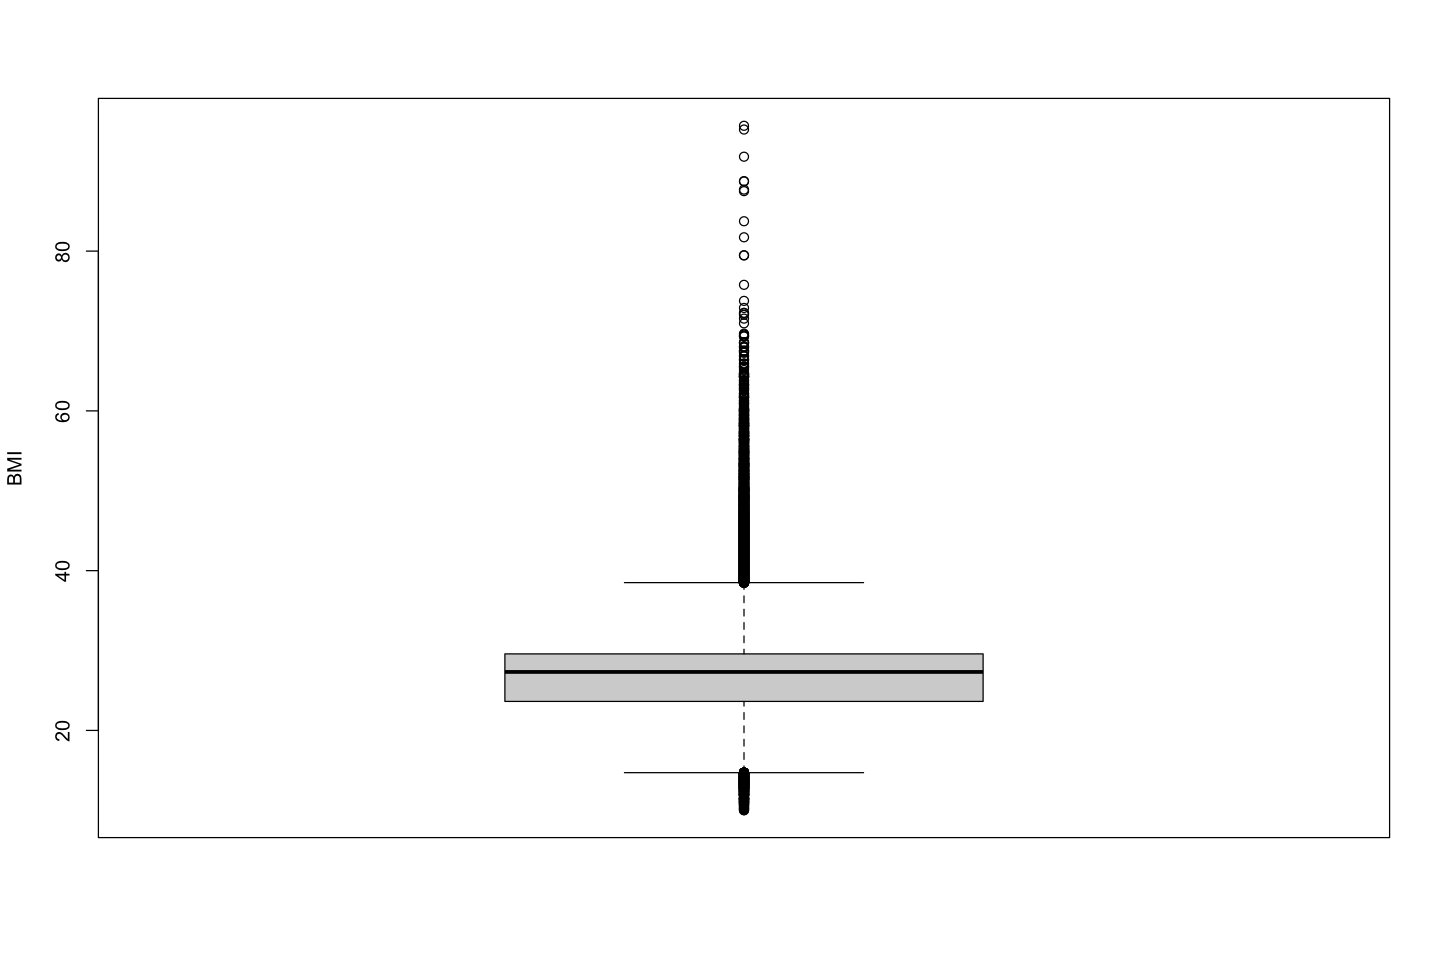

In [34]:
boxplot(df$bmi, ylab='BMI')

In [35]:
# Identifying rows with outliers for BMI
bmi.out <- boxplot.stats(df$bmi)$out
bmi.ind <- which(df$bmi %in% c(bmi.out))

### HbA1c

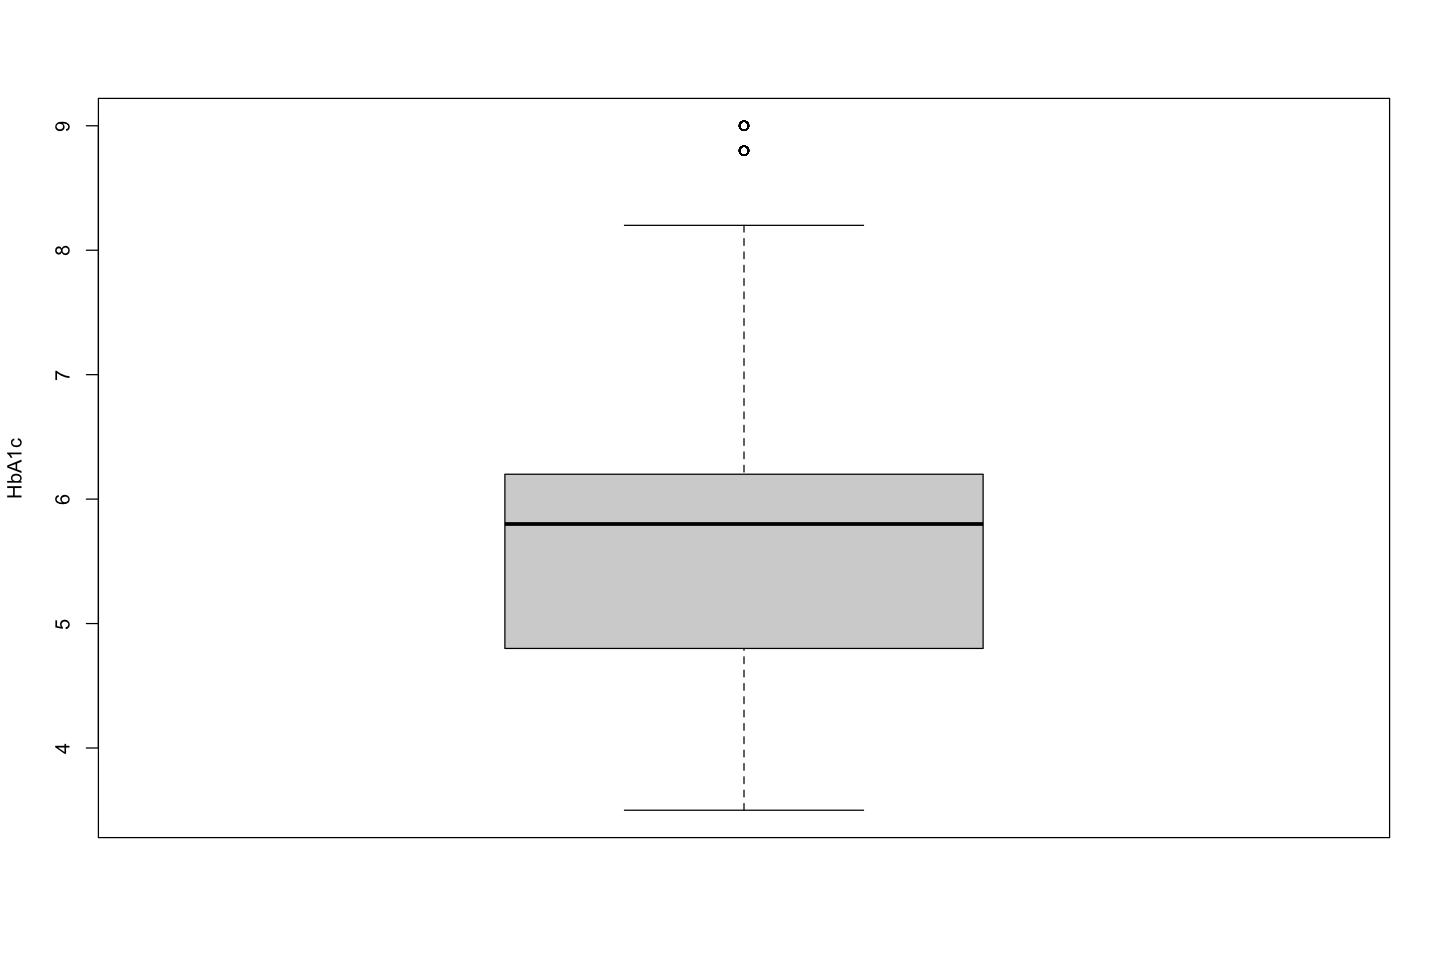

In [36]:
boxplot(df$HbA1c_level, ylab='HbA1c')

In [37]:
# Identifying rows with outliers for HbA1c
HbA1c.out <- boxplot.stats(df$HbA1c_level)$out
HbA1c.ind <- which(df$HbA1c_level %in% c(HbA1c.out))

### Blood Glucose Level

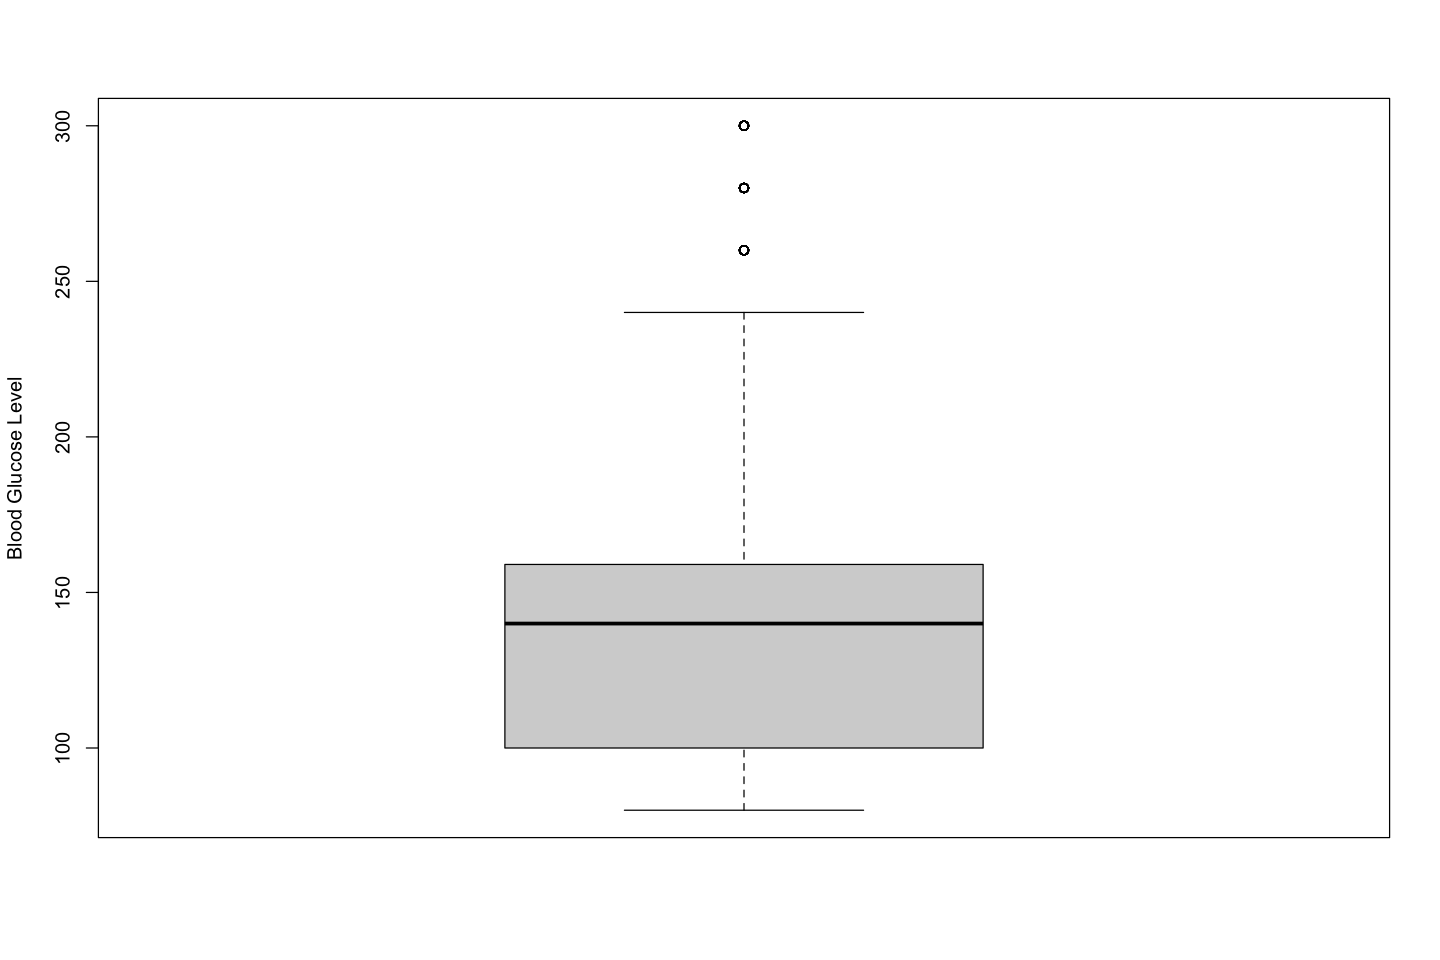

In [38]:
boxplot(df$blood_glucose_level, ylab='Blood Glucose Level')

In [39]:
# Identifying rows with outliers for Blood Glucose Levels
blood.glucose.out <- boxplot.stats(df$blood_glucose_level)$out
blood.glucose.ind <- which(df$blood_glucose_level %in% c(blood.glucose.out))

In [40]:
# Removing outliers from data set
df <- df[-c(bmi.ind, HbA1c.ind, blood.glucose.ind),]

In [41]:
# Shortening variable names
names(df) <- c('GEND', 'AGE','HYTN', 'HRD', 'SMK', 'BMI','HBA1C','BGLU', 'DBTS')

Key of Variable Names

- Gender (GEND)
- Age (AGE)
- Hypertension (HYTN)
- Heart Disease (HRD)
- Smoking (SMK)
- Body Mass Index (BMI)
- HbA1c Level (HBA1C)
- Blood Glucose Level (BGLU)
- Diabetes (DBTS)

In [42]:
# Converting appropraite columns to a factor
df <- df %>% mutate_at(c('GEND', 'HYTN', 'HRD', 'SMK', 'DBTS'), as.factor)

In [43]:
summary(df)

     GEND            AGE        HYTN      HRD                SMK       
 Female:52536   Min.   : 0.08   0:84453   0:87167   current    : 8316  
 Male  :37834   1st Qu.:23.00   1: 5934   1: 3220   ever       : 3542  
 Other :   17   Median :42.00                       former     : 8065  
                Mean   :41.41                       never      :31441  
                3rd Qu.:59.00                       No Info    :33260  
                Max.   :80.00                       not current: 5763  
      BMI            HBA1C            BGLU       DBTS     
 Min.   :14.71   Min.   :3.500   Min.   : 80.0   0:85892  
 1st Qu.:23.37   1st Qu.:4.800   1st Qu.:100.0   1: 4495  
 Median :27.32   Median :5.800   Median :140.0            
 Mean   :26.32   Mean   :5.456   Mean   :134.6            
 3rd Qu.:28.28   3rd Qu.:6.200   3rd Qu.:158.0            
 Max.   :38.50   Max.   :8.200   Max.   :240.0            

In [44]:
# Removing rows with gender as 'Other'
df <- df[df$GEND != 'Other', ]

# Removing unused levels
df <- droplevels(df)

In [45]:
# Creating training and test sets
train.indices <- createDataPartition(df$DBTS, times=1, p=0.8, list=FALSE)

training <- df[train.indices,]
testing <- df[-train.indices,]

dim(training)
dim(testing)

[1] 72296     9

[1] 18074     9

In [46]:
# Checking if the response variable is balanced
prop.table(table(training$DBTS))


         0          1 
0.95026004 0.04973996 

Based on the output of the cell above, the response variable in the training data is imbalanced. Specfifically, there is a disproportionate number of participants (95%) without diabetes. Training the model with an imbalanced dataset would likely affect the model's ability to predict minority cases (i.e., people with diabetes), which would limit the utility of the tool. To address this issue, Random Oversampling Examples or ROSE will be used on the training data.

### ROSE Procedure

In [47]:
# ROSE procedure
set.seed(111)

training.rose <- ROSE(DBTS ~., data=training)$data

prop.table(table(training.rose$DBTS))


        0         1 
0.5010374 0.4989626 

After using the ROSE procedure, the response variable in the training data is more balanced (approximately 50/50). 

## Feature Selection

When building a predictive model, it is important to only include important variables. One way to select which variables should be included in a model is through the Boruta algorithm.

### Boruta Algorithm

In [48]:
boruta.selection <- Boruta(DBTS ~ ., data=training.rose)

boruta.selection

Boruta performed 10 iterations in 3.603766 mins.
 8 attributes confirmed important: AGE, BGLU, BMI, GEND, HBA1C and 3
more;
 No attributes deemed unimportant.

Based on the results of the Boruta function, it appears that all variables included in the data set are important and should be included in the model. 

To provide a fine-graned analysis of the predictor variables, a plot was generated below.

### Plot

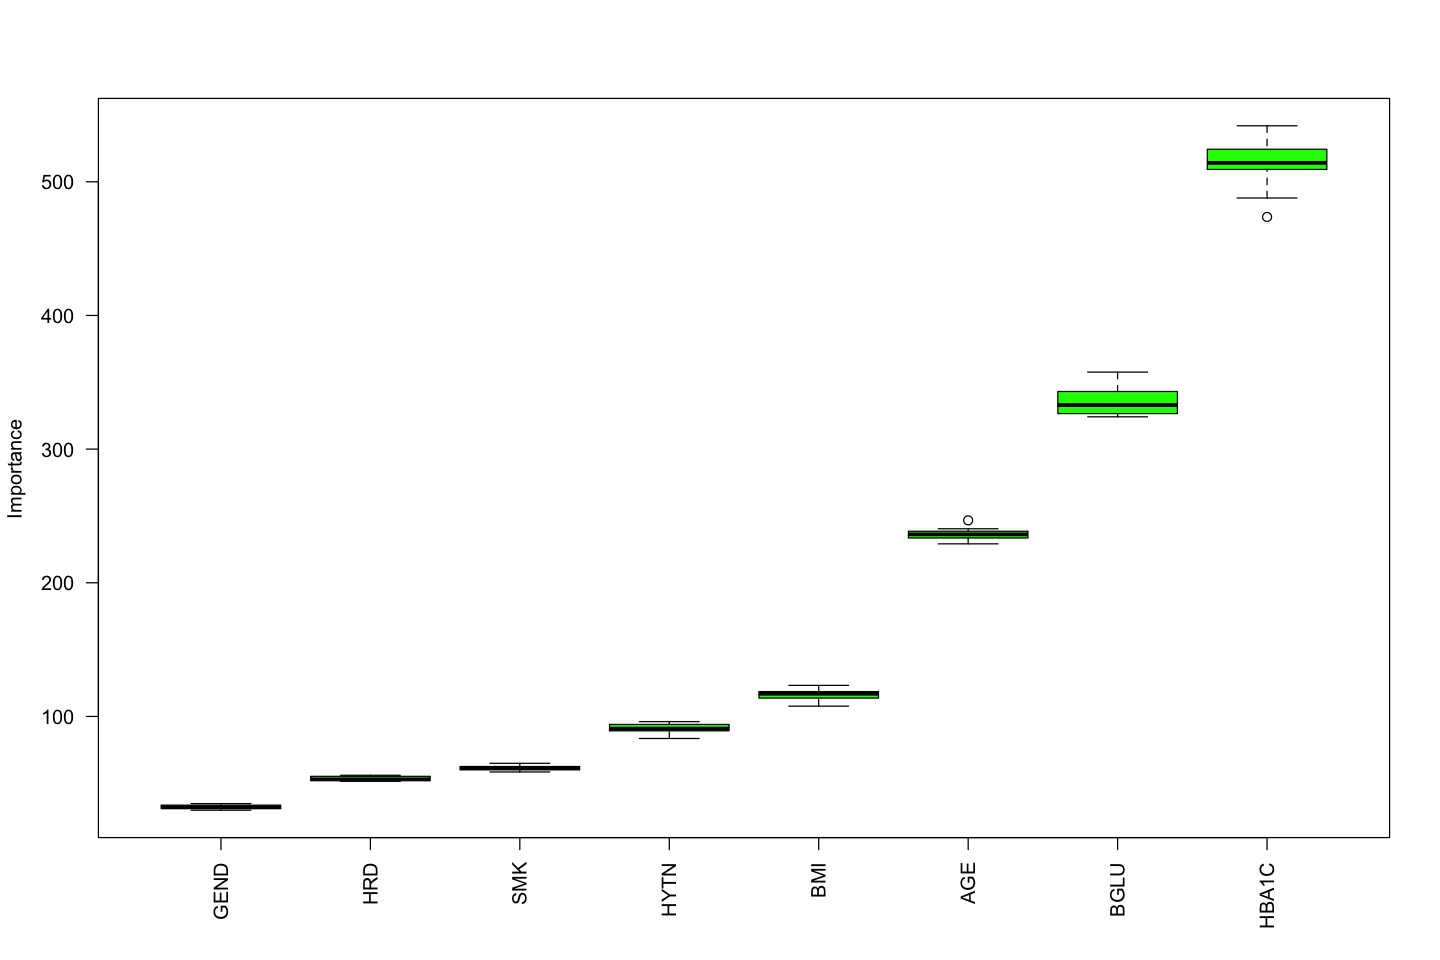

In [49]:
plot(boruta.selection, whichShadow=c(FALSE, FALSE, FALSE), las=2, xlab='')

In [50]:
attStats(boruta.selection)

,meanImp,medianImp,minImp,maxImp,normHits,decision
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GEND,32.21605,32.05883,29.83918,34.78779,1,Confirmed
AGE,236.69745,236.22526,229.12983,246.70920,1,Confirmed
HYTN,91.11781,90.93020,83.50569,96.09122,1,Confirmed
HRD,53.38245,52.92089,51.42531,55.98545,1,Confirmed
SMK,61.35792,61.41991,58.44564,64.93556,1,Confirmed
BMI,116.39099,116.97444,107.69570,123.23633,1,Confirmed
HBA1C,512.46368,514.16966,473.68670,541.90255,1,Confirmed
BGLU,336.06143,332.94065,324.16908,357.60712,1,Confirmed


Based on the plot above, HbA1c is the most important predictor variable and Gender is the least important predictor variable. 

---

## Model Training

### Full Model

In [51]:
full.model <- glm(DBTS ~ ., family='binomial', data=training.rose)

full.model.summary <- summary(full.model)

full.model.summary


Call:
glm(formula = DBTS ~ ., family = "binomial", data = training.rose)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3167  -0.4085  -0.0104   0.4806   3.4250  

Coefficients:
                  Estimate  Std. Error  z value  Pr(>|z|)    
(Intercept)    -20.1974266   0.1735441 -116.382   < 2e-16 ***
GENDMale         0.1961548   0.0235054    8.345   < 2e-16 ***
AGE              0.0459395   0.0006566   69.969   < 2e-16 ***
HYTN1            0.8604139   0.0356553   24.131   < 2e-16 ***
HRD1             0.9120683   0.0464751   19.625   < 2e-16 ***
SMKever         -0.0299109   0.0622578   -0.480  0.630917    
SMKformer       -0.0592562   0.0474589   -1.249  0.211819    
SMKnever        -0.1649103   0.0397295   -4.151 0.0000331 ***
SMKNo Info      -0.6557440   0.0422369  -15.525   < 2e-16 ***
SMKnot current  -0.2092296   0.0552757   -3.785  0.000154 ***
BMI              0.0973711   0.0026247   37.098   < 2e-16 ***
HBA1C            1.8506415   0.0194484   95.157   < 2

### Reduced Model

In [52]:
reduced.model <- glm(DBTS ~ GEND + AGE + HYTN + HRD + BMI + HBA1C + BGLU, family='binomial', data=training.rose)

reduced.model.summary <- summary(reduced.model)

reduced.model.summary


Call:
glm(formula = DBTS ~ GEND + AGE + HYTN + HRD + BMI + HBA1C + 
    BGLU, family = "binomial", data = training.rose)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3413  -0.4177  -0.0119   0.4871   3.3341  

Coefficients:
               Estimate  Std. Error  z value Pr(>|z|)    
(Intercept) -20.6328478   0.1705824 -120.955   <2e-16 ***
GENDMale      0.2015476   0.0232158    8.681   <2e-16 ***
AGE           0.0466607   0.0006408   72.811   <2e-16 ***
HYTN1         0.9192215   0.0354073   25.961   <2e-16 ***
HRD1          0.9282869   0.0462044   20.091   <2e-16 ***
BMI           0.1012773   0.0026012   38.935   <2e-16 ***
HBA1C         1.8531106   0.0193725   95.657   <2e-16 ***
BGLU          0.0256748   0.0003584   71.645   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 100223  on 72295  degrees of freedom
Residual deviance:  47828  on 72288  degrees 

---

## Model Performance

In [53]:
# Variables to calculate confusion matrix
actual.values <- testing$DBTS

full.prob <- predict(full.model, newdata=testing, type='response')
full.pred <- ifelse(full.prob > 0.5, 1, 0)

reduced.prob <- predict(reduced.model, newdata=testing, type='response')
reduced.pred <- ifelse(reduced.prob > 0.5, 1, 0)

#### Full Model

In [54]:
confusionMatrix(as.factor(full.pred), as.factor(actual.values))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 14538   114
         1  2637   785
                                         
               Accuracy : 0.8478         
                 95% CI : (0.8425, 0.853)
    No Information Rate : 0.9503         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.3089         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.8465         
            Specificity : 0.8732         
         Pos Pred Value : 0.9922         
         Neg Pred Value : 0.2294         
             Prevalence : 0.9503         
         Detection Rate : 0.8044         
   Detection Prevalence : 0.8107         
      Balanced Accuracy : 0.8598         
                                         
       'Positive' Class : 0              
                                      

#### Reduced Model

In [55]:
confusionMatrix(as.factor(reduced.pred), as.factor(actual.values))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 14528   128
         1  2647   771
                                          
               Accuracy : 0.8465          
                 95% CI : (0.8411, 0.8517)
    No Information Rate : 0.9503          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3022          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8459          
            Specificity : 0.8576          
         Pos Pred Value : 0.9913          
         Neg Pred Value : 0.2256          
             Prevalence : 0.9503          
         Detection Rate : 0.8038          
   Detection Prevalence : 0.8109          
      Balanced Accuracy : 0.8518          
                                          
       'Positive' Class : 0               
                  

The full and reduced model have similar accuracy, sensitivity, and specificity. Due to the reduced number of predictor variables, the reduced model will be used in the web app. 